Epoch 1, Iter 1, Loss=0.6854


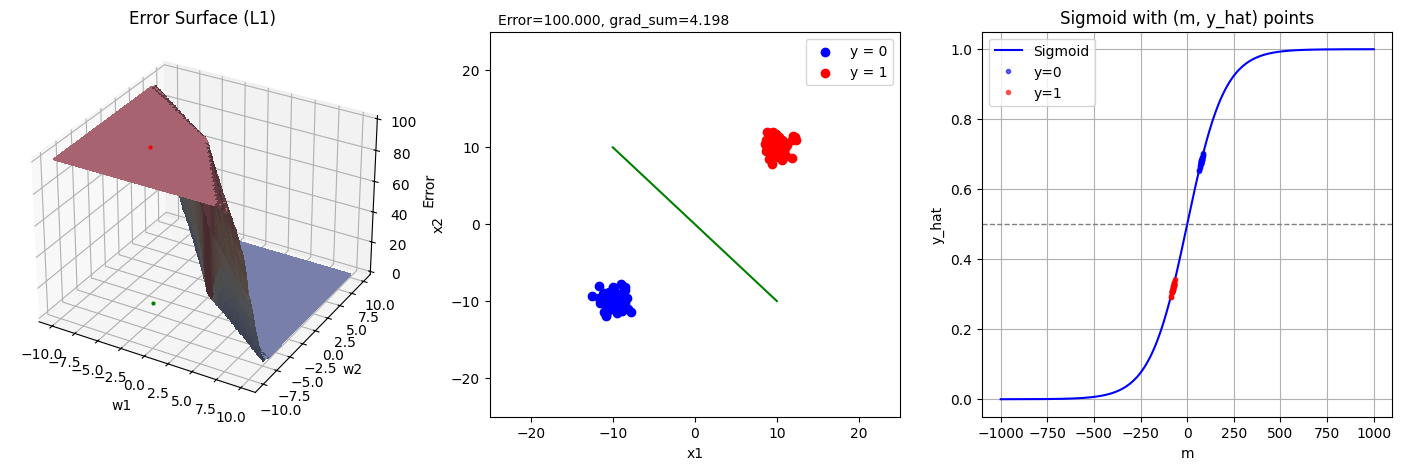

Epoch 1, Iter 2, Loss=0.6569
Epoch 1, Iter 3, Loss=0.6695
Epoch 1, Iter 4, Loss=0.6549
Epoch 1, Iter 5, Loss=0.6501
Epoch 1, Iter 6, Loss=0.6225
Epoch 1, Iter 7, Loss=0.6353
Epoch 1, Iter 8, Loss=0.6231
Epoch 1, Iter 9, Loss=0.6063
Epoch 1, Iter 10, Loss=0.6001
Epoch 1, Iter 11, Loss=0.5961
Epoch 1, Iter 12, Loss=0.5801
Epoch 1, Iter 13, Loss=0.5679
Epoch 1, Iter 14, Loss=0.5497
Epoch 1, Iter 15, Loss=0.5468
Epoch 1, Iter 16, Loss=0.5232


KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------- Data -----------------
np.random.seed(0)
data0 = np.random.randn(50, 2) + [-10, -10]
data1 = np.random.randn(50, 2) + [10, 10]
data = np.concatenate((data0, data1), axis=0)
labels = np.array([0]*50 + [1]*50)
indices = np.random.permutation(len(data))
data = data[indices]
labels = labels[indices]

# Add bias term x0=1
data = np.hstack((np.ones((data.shape[0], 1)), data))

# ----------------- Model -----------------
def sigmoid(m):
    # change this variable k
    k = 0.01
    return 1 / (1 + np.exp(-k*m)) 

def forward(x, w):
    """Forward pass: m -> sigmoid(m)"""
    m = np.dot(w, x)
    y_hat = sigmoid(m)
    return m, y_hat

# ----------------- Losses and Gradients -----------------
def loss_l1(y_hat, y):
    return np.abs(y - y_hat)

def grad_l1(x, y, w, cache):
    """
    L = |y_hat - y|
    y_hat = sigmoid(m)
    m = w·x

    dL/dy_hat = -sign(y - y_hat)
    dy_hat/dm = y_hat * (1 - y_hat)
    dm/dw_j = x_j

    => dL/dw = -sign(y - y_hat) * y_hat * (1 - y_hat) * x
    """
    m, y_hat = cache
    return -np.sign(y - y_hat) * y_hat * (1 - y_hat) * x

def loss_l2(y_hat, y):
    return (y - y_hat)**2

def grad_l2(x, y, w, cache):
    """
    L = (y_hat - y)^2
    y_hat = sigmoid(m)
    m = w·x

    dL/dy_hat = -2 * (y - y_hat)
    dy_hat/dm = y_hat * (1 - y_hat)
    dm/dw_j = x_j

    => dL/dw = -2 * (y - y_hat) * y_hat * (1 - y_hat) * x
    """
    m, y_hat = cache
    return -2 * (y - y_hat) * y_hat * (1 - y_hat) * x

def loss_ce(y_hat, y):
    eps = 1e-12
    return -(y*np.log(y_hat+eps) + (1-y)*np.log(1-y_hat+eps))

def grad_ce(x, y, w, cache):
    """
    Chain rule:
    m = w·x
    y_hat = sigmoid(m)
    L = -[ y log(y_hat) + (1-y) log(1-y_hat) ]

    => dL/dw = -(y / y_hat) + ((1-y) / (1-y_hat)) * y_hat * (1-y_hat) * x
    """
    m, y_hat = cache
    return -(y / (y_hat + 1e-12)) + ((1-y) / (1 - y_hat + 1e-12)) * y_hat * (1 - y_hat) * x

loss_and_gradients = {
    "l1": (loss_l1, grad_l1),
    "l2": (loss_l2, grad_l2),
    "ce": (loss_ce, grad_ce)
}

# ----------------- Precompute Error Surface -----------------
w0 = 0
w1_range = np.linspace(-10, 10, 100)
w2_range = np.linspace(-10, 10, 100)
w1, w2 = np.meshgrid(w1_range, w2_range)
error_surface = np.zeros_like(w1)

for i in range(w1.shape[0]):
    for j in range(w1.shape[1]):
        params = np.array([w0, w1[i, j], w2[i, j]])
        preds = np.array([1 if sigmoid(np.dot(params, x)) >= 0.5 else 0 for x in data])
        error_surface[i, j] = np.sum(preds != labels)

norm = plt.Normalize(vmin=error_surface.min(), vmax=error_surface.max())

# ----------------- Unified Gradient Descent -----------------
def train(X, y, lr=0.1, epochs=10, pause_time=0.01, loss_type="l2"):
    if loss_type not in loss_and_gradients:
        raise ValueError(f"Unknown loss type '{loss_type}'. Choose from {list(loss_and_gradients.keys())}")
    loss_fn, backward = loss_and_gradients[loss_type]

    w = -4*np.ones(3)
    w[0] = 0
    path_w = []

    plt.ion()
    fig = plt.figure(figsize=(18, 5))

    # ---- (1) Error surface subplot ----
    ax1 = fig.add_subplot(1, 3, 1, projection='3d')
    colors = plt.cm.coolwarm(norm(error_surface))
    light_factor = 0.5
    colors[..., :3] = colors[..., :3]*(1-light_factor)+light_factor
    ax1.plot_surface(w1, w2, error_surface, facecolors=colors,
                     rstride=1, cstride=1, antialiased=False, alpha=0.5, zorder=0)
    path_line, = ax1.plot([], [], [], color='red', marker='o', markersize=2, linewidth=1)
    path_linew, = ax1.plot([], [], [], color='green', marker='o', markersize=2, linewidth=1)
    ax1.set_xlabel('w1')
    ax1.set_ylabel('w2')
    ax1.set_zlabel('Error')
    ax1.set_title(f'Error Surface ({loss_type.upper()})')

    # ---- (2) Decision boundary subplot ----
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.scatter(data0[:, 0], data0[:, 1], color='blue', label='y = 0')
    ax2.scatter(data1[:, 0], data1[:, 1], color='red', label='y = 1')
    ax2.set_xlim(-25, 25)
    ax2.set_ylim(-25, 25)
    ax2.set_xlabel('x1')
    ax2.set_ylabel('x2')
    ax2.legend()
    boundary_line, = ax2.plot([], [], color='green', label='Current Boundary')
    param_text = ax2.text(0.02, 1.02, '', transform=ax2.transAxes, fontsize=10)

    # ---- (3) Sigmoid m vs y_hat subplot ----
    ax3 = fig.add_subplot(1, 3, 3)
    m_plot = np.linspace(-1000, 1000, 500)
    ax3.plot(m_plot, sigmoid(m_plot), label='Sigmoid', color='blue')
    ax3.axhline(0.5, color='gray', linestyle='--', linewidth=1)

    scatter_m0, = ax3.plot([], [], 'bo', markersize=3, alpha=0.6, label='y=0')
    scatter_m1, = ax3.plot([], [], 'ro', markersize=3, alpha=0.6, label='y=1')

    ax3.set_xlabel('m')
    ax3.set_ylabel('y_hat')
    ax3.set_title('Sigmoid with (m, y_hat) points')
    ax3.legend()
    ax3.grid(True)

    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(zip(X, y)):
            m, y_hat = forward(xi, w)
            loss = loss_fn(yi, y_hat)
            grad = backward(xi, yi, w, (m, y_hat))
            w[1:] -= lr * grad[1:]

            preds = np.array([1 if sigmoid(np.dot(w, x)) >= 0.5 else 0 for x in X])
            current_error = np.sum(preds != y)

            path_w.append((w[1], w[2], current_error))
            path_array = np.array(path_w)

            path_line.set_data(path_array[:, 0], path_array[:, 1])
            path_line.set_3d_properties(path_array[:, 2] + 0.5)
            path_line.set_zorder(10)

            path_linew.set_data(path_array[:, 0], path_array[:, 1])
            path_linew.set_3d_properties(0)

            param_text.set_text(
                f"Error={current_error:.3f}, grad_sum={np.abs(grad[1])+np.abs(grad[2]):.3f}"
            )

            if w[2] != 0:
                x1_vals = np.linspace(-10, 10, 100)
                x2_vals = -(w[1]*x1_vals + w[0]) / w[2]
            else:
                x1_vals = np.full(100, -w[0]/w[1])
                x2_vals = np.linspace(-10, 10, 100)
            boundary_line.set_data(x1_vals, x2_vals)

            # Update sigmoid subplot points by label
            m0, yhat0, m1, yhat1 = [], [], [], []
            for xi2, yi2 in zip(X, y):
                m2, y_hat2 = forward(xi2, w)
                if yi2 == 0:
                    m0.append(m2)
                    yhat0.append(y_hat2)
                else:
                    m1.append(m2)
                    yhat1.append(y_hat2)

            scatter_m0.set_data(m0, yhat0)
            scatter_m1.set_data(m1, yhat1)

            print(f"Epoch {epoch+1}, Iter {i+1}, Loss={loss:.4f}")
            plt.pause(pause_time)

            if current_error < 1e-5:
                break

    plt.ioff()
    plt.show()
    return w

# ----------------- Run with CE loss -----------------
w_learned = train(data, labels, lr=0.1, epochs=20, pause_time=5, loss_type="l1")
print(f"Learned weights: {w_learned}")